In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

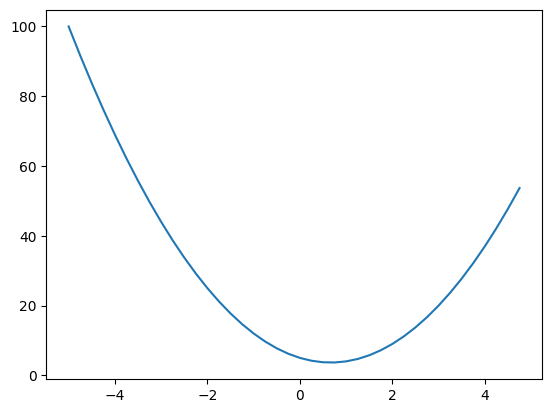

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [148]:
class Value:

    def __init__(self, data, child=(), op='', label=''):
        self.data = data
        self.prev = set(child)
        self.backward = lambda: None
        self.grad = 0.0
        self.op = op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out.backward = backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def backward():
            self.grad += (other.data*out.grad)
            other.grad += (self.data*out.grad)

        out.backward = backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def backward():
            self.grad += other * (self.data**(other-1)) * out.grad
            
        out.backward = backward
        return out

    def __rmul__(self, other):
        return self*other

    def __truediv__(self, other):
        return self*(other**-1)

    def __neg__(self):
        return self*-1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self+other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
            self.grad += (1 - t**2)*out.grad
            
        out.backward = backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def backward():
            self.grad += (out.grad*out.data)
            
        out.backward = backward
        return out

    def backPropagate(self):
        self.grad = 1.0

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node.backward()

In [149]:
a = Value(2)
b = Value(2)
a - b

Value(data=0)

In [66]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

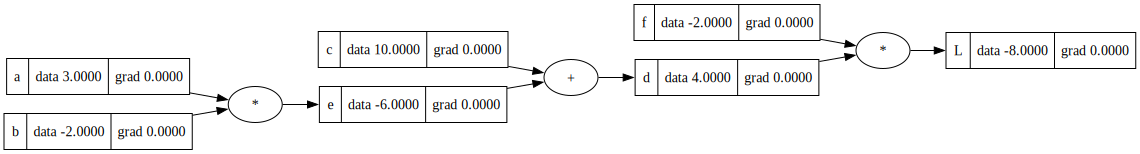

In [13]:
draw_dot(L)

In [14]:
import os
print("dot" in os.environ["PATH"])


False


In [15]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

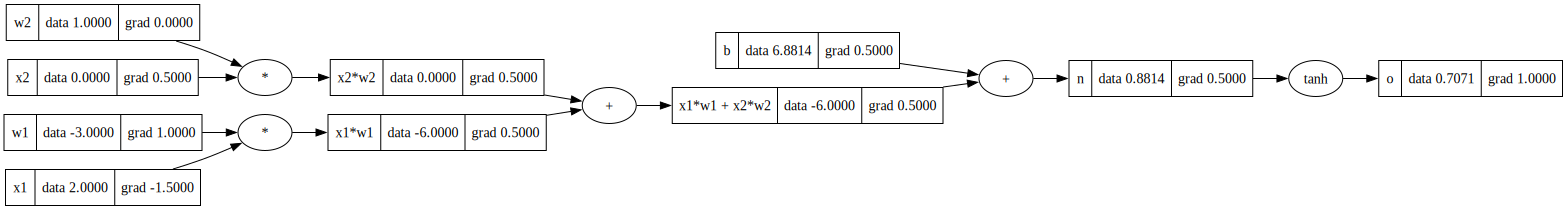

In [106]:
# inputs(x1, x2)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights(w1, w2)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1w1+x2w2+b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

o.backPropagate()
draw_dot(o)

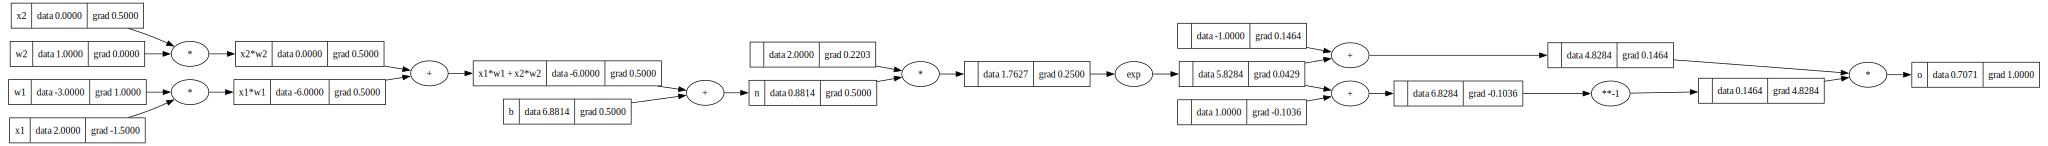

In [150]:
# inputs(x1, x2)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights(w1, w2)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1w1+x2w2+b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1); o.label='o'

o.backPropagate()
draw_dot(o)

In [163]:
import torch
import random

In [161]:
x1 = torch.tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b

o = torch.tanh(n)
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [175]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
     
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [176]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8929786769535201)

In [177]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [194]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backPropagate()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.018488595098857995
1 0.017549023598976022
2 0.01669529929306514
3 0.015916401663810784
4 0.015203103824472472
5 0.014547622856326405
6 0.013943348904847913
7 0.013384633041124964
8 0.012866619512459362
9 0.012385111900716258
10 0.01193646544927146
11 0.011517499777697364
12 0.011125427619882469
13 0.010757796258150928
14 0.010412439093235595
15 0.010087435363524183
16 0.00978107645980401
17 0.009491837611198463
18 0.009218353970858807
19 0.008959400325555943


In [195]:
ypred

[Value(data=0.9534160308002353),
 Value(data=-0.9783657022412054),
 Value(data=-0.9402897263328601),
 Value(data=0.9475026237014611)]

In [ ]:
[Value(data=-0.8929786769535201),
 Value(data=-0.6717936432662357),
 Value(data=-0.8294647001441317),
 Value(data=-0.6290985601051888)]